/opt/anaconda3/envs/SDP/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8431 - loss: 2.2276 - val_accuracy: 0.9740 - val_loss: 1.7017 - learning_rate: 1.0000e-04
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9759 - loss: 1.6011 - val_accuracy: 0.9792 - val_loss: 1.3368 - learning_rate: 1.0000e-04
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9861 - loss: 1.2447 - val_accuracy: 0.9771 - val_loss: 1.0399 - learning_rate: 1.0000e-04
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9843 - loss: 0.9720 - val_accuracy: 0.9750 - val_loss: 0.8069 - learning_rate: 1.0000e-04
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9878 - loss: 0.7388 - val_accuracy: 0.9802 - val_loss: 0.6267 - learning_rate: 1.0000e-04
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9844 - loss: 0.5787 - val_accuracy: 0.9729 - val_loss: 0.5015 - learning_rate: 1.0000e-04
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - acc

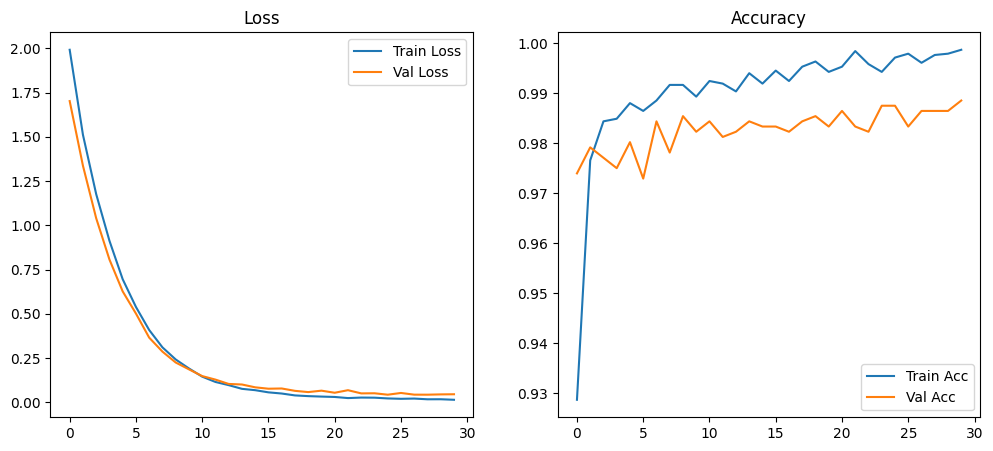

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc


def get_feature_paths(folder_path, feature_type):
    return [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(f'_{feature_type}.npy')
    ]

bio_features_dir = '/Users/dhanarahulsainadiminti/Library/Mobile Documents/com~apple~CloudDocs/dataset_SDP/Bio/features'
non_bio_features_dir = '/Users/dhanarahulsainadiminti/Library/Mobile Documents/com~apple~CloudDocs/dataset_SDP/non-bio/features'

bio_mfcc_files = get_feature_paths(bio_features_dir, 'mfcc')
bio_spec_files = get_feature_paths(bio_features_dir, 'spectrogram')
bio_chroma_files = get_feature_paths(bio_features_dir, 'chroma')

non_bio_mfcc_files = get_feature_paths(non_bio_features_dir, 'mfcc')
non_bio_spec_files = get_feature_paths(non_bio_features_dir, 'spectrogram')
non_bio_chroma_files = get_feature_paths(non_bio_features_dir, 'chroma')

bio_labels = [1] * len(bio_mfcc_files)
non_bio_labels = [0] * len(non_bio_mfcc_files)

train_mfcc, test_mfcc, train_spec, test_spec, train_chroma, test_chroma, y_train, y_test = train_test_split(
    bio_mfcc_files + non_bio_mfcc_files,
    bio_spec_files + non_bio_spec_files,
    bio_chroma_files + non_bio_chroma_files,
    bio_labels + non_bio_labels,
    test_size=0.2,
    random_state=42
)

gc.collect()


def pad_or_crop(feature, expected_shape):
    feature = np.array(feature)
    current_shape = feature.shape
    if current_shape == expected_shape:
        return feature
    padded = np.zeros(expected_shape, dtype=np.float32)
    min_shape = tuple(min(current_shape[i], expected_shape[i]) for i in range(len(expected_shape)))
    slices = tuple(slice(0, min_shape[i]) for i in range(len(expected_shape)))
    padded[slices] = feature[slices]
    return padded

def augment_data(feature_array, noise_factor=0.005):
    noise = np.random.randn(*feature_array.shape).astype(np.float32) * noise_factor
    return feature_array + noise


class SpectrogramDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_files, spec_files, chroma_files, labels,
                 batch_size=32, shuffle=True, augment=False):
        self.mfcc_files = mfcc_files
        self.spec_files = spec_files
        self.chroma_files = chroma_files
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.labels))
        self.expected_mfcc_shape = (13, 430)
        self.expected_spec_shape = (1025, 430)
        self.expected_chroma_shape = (12, 430)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.labels) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mfcc = [self.mfcc_files[i] for i in batch_indexes]
        batch_spec = [self.spec_files[i] for i in batch_indexes]
        batch_chroma = [self.chroma_files[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        X_mfcc, X_spec, X_chroma = [], [], []
        for mfcc_path, spec_path, chroma_path in zip(batch_mfcc, batch_spec, batch_chroma):
            mfcc = pad_or_crop(np.load(mfcc_path).astype(np.float32), self.expected_mfcc_shape)
            spec = pad_or_crop(np.load(spec_path).astype(np.float32), self.expected_spec_shape)
            chroma = pad_or_crop(np.load(chroma_path).astype(np.float32), self.expected_chroma_shape)
            if self.augment:
                mfcc = augment_data(mfcc, 0.005)
                spec = augment_data(spec, 0.001)
            X_mfcc.append(mfcc)
            X_spec.append(spec)
            X_chroma.append(chroma)

        return (np.array(X_mfcc), np.array(X_spec), np.array(X_chroma)), np.array(batch_labels, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_generator = SpectrogramDataGenerator(train_mfcc, train_spec, train_chroma, y_train, augment=True)
test_generator = SpectrogramDataGenerator(test_mfcc, test_spec, test_chroma, y_test, shuffle=False)


def transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.2):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    res = x
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return layers.LayerNormalization(epsilon=1e-6)(x + res)


class GraphAttentionFusion(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GraphAttentionFusion, self).__init__(**kwargs)
        self.att_dense = layers.Dense(1, activation='tanh')

    def call(self, inputs):
       
        x = tf.stack(inputs, axis=1) 
        attention_scores = self.att_dense(x) 
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        weighted_sum = tf.reduce_sum(x * attention_weights, axis=1)
        return weighted_sum


input_mfcc = Input(shape=(13, 430))
input_spec = Input(shape=(1025, 430))
input_chroma = Input(shape=(12, 430))

mfcc_encoded = transformer_encoder(input_mfcc)
spec_encoded = transformer_encoder(input_spec)
chroma_encoded = transformer_encoder(input_chroma)

mfcc_embed = layers.GlobalAveragePooling1D()(mfcc_encoded)
spec_embed = layers.GlobalAveragePooling1D()(spec_encoded)
chroma_embed = layers.GlobalAveragePooling1D()(chroma_encoded)


fused = GraphAttentionFusion()([mfcc_embed, spec_embed, chroma_embed])

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fused)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[input_mfcc, input_spec, input_chroma], outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(train_generator, validation_data=test_generator,
                    epochs=30, callbacks=[reduce_lr, early_stop])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.show()

In [3]:
model.save("novel.h5")

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step


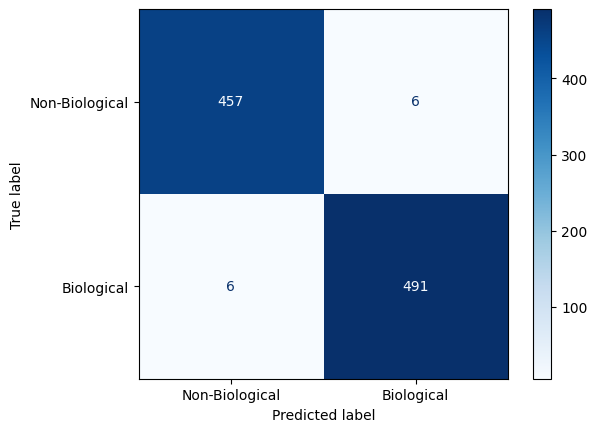

In [8]:

y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)


y_true_trimmed = np.array(y_test[:len(y_pred)])


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_trimmed, y_pred)
labels = ['Non-Biological', 'Biological']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')